In this notebook,I will introduce:
+ Necessary libraries

+ Load the dataset

+ Data Exploration

+ Preprocess the data

+ Train model

+ Generate the submission file

## Necessary libraries ##

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re
import sklearn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import torch.nn.functional as F
from collections import Counter
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt 
import seaborn as sns 

## Load the dataset ##

Train and test dataset contain:

+ id

+ keyword

+ location

+ text

+ target

This task is text classification. The target is 1, which means it is a real disaster, otherwise it is 0.

In [2]:
import pandas as pd
train_data=pd.read_csv("D:/kaggle/input/nlp-getting-started/train.csv")
test_data=pd.read_csv("D:/kaggle/input/nlp-getting-started/test.csv")

## Data Exploration ##

In [3]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
#check miss value
train_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

The dataset is fine.The task is text classification. Locations and keywords have little impact on the results. As long as the text and targets are not missing, it will be fine.

In [7]:
train_data["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [3]:
train_data["length"]=train_data["text"].apply(len)
train_data.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [10]:
train_data['length'].describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

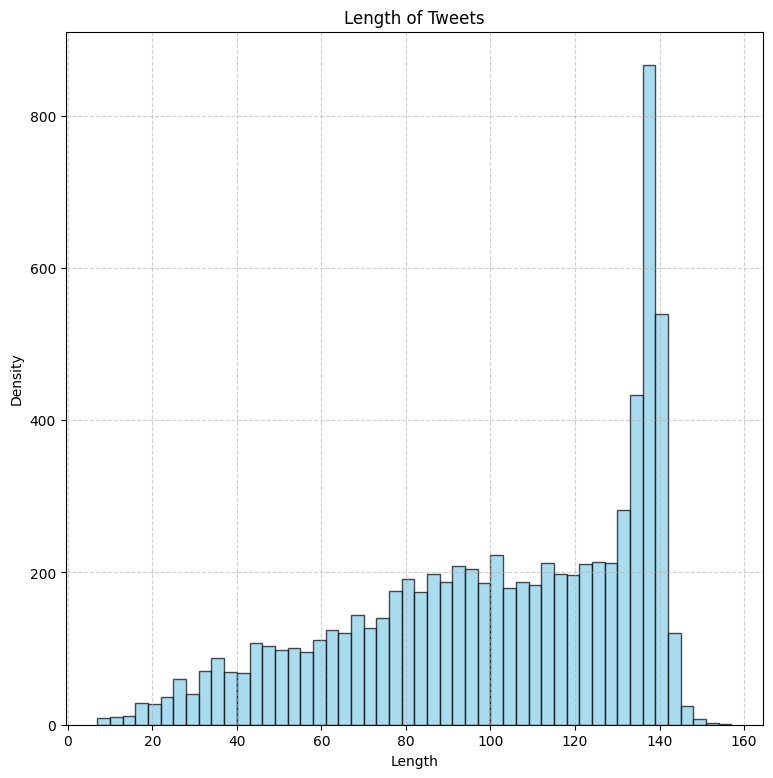

In [4]:
import matplotlib.pyplot as plt 

def plot_tweet_length_histogram(data):
    plt.figure(figsize=(9, 9))
    plt.hist(data["length"], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title("Length of Tweets")
    plt.xlabel("Length")
    plt.ylabel("Density")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


plot_tweet_length_histogram(train_data)

## Preprocess the data ##

In [3]:
def preprocess_text(text):
    
    # Lowercasing
    text = text.lower()
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Removing special characters and punctuation
    table = str.maketrans('', '', string.punctuation)
    tokens = [token.translate(table) for token in tokens]
    
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Removing URLs, replace by 'URL'
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    tokens = [re.sub(url_pattern, 'URL', token) for token in tokens]
    
    # Removing HTML beacons, assuming 'html' as a keyword
    tokens = [token for token in tokens if 'html' not in token]
    
    # Removing numbers, replace by 'number'
    tokens = [re.sub(r'\d+', 'number', token) for token in tokens]
    
    # Removing emojis, replace by 'emoji'
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    tokens = [re.sub(emoji_pattern, 'emoji', token) for token in tokens]
    
 
    return tokens


In [8]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re
train_data['text'] = train_data['text'].apply(preprocess_text)
train_data.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,"[deeds, reason, , earthquake, may, allah, forg...",1,69
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, , canada]",1,38
2,5,NaN,NaN,"[residents, asked, shelter, place, , notified,...",1,133
3,6,NaN,NaN,"[number, people, receive, , wildfires, evacuat...",1,65
4,7,NaN,NaN,"[got, sent, photo, ruby, , alaska, smoke, , wi...",1,88


In [7]:
train_data["length"]=train_data["text"].apply(len)
train_data.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,"[deeds, reason, , earthquake, may, allah, forg...",1,8
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, , canada]",1,8
2,5,NaN,NaN,"[residents, asked, shelter, place, , notified,...",1,13
3,6,NaN,NaN,"[number, people, receive, , wildfires, evacuat...",1,8
4,7,NaN,NaN,"[got, sent, photo, ruby, , alaska, smoke, , wi...",1,11


In [8]:
train_data['length'].describe()

count    7613.000000
mean       13.978327
std         5.459585
min         1.000000
25%        10.000000
50%        14.000000
75%        18.000000
max        67.000000
Name: length, dtype: float64

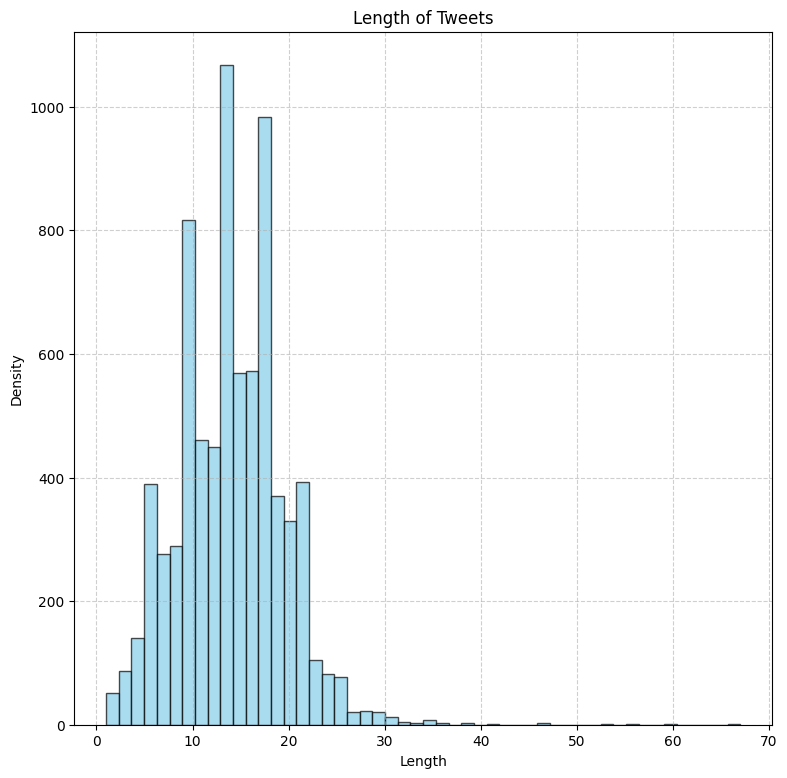

In [11]:
import matplotlib.pyplot as plt 

def plot_tweet_length_histogram(data):
    plt.figure(figsize=(9, 9))
    plt.hist(data["length"], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title("Length of Tweets")
    plt.xlabel("Length")
    plt.ylabel("Density")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Assuming train_data is your DataFrame containing tweet lengths
plot_tweet_length_histogram(train_data)

In order to improve computational efficiency, we will process small batches of text sequences through truncation and padding. Assuming that each sequence in the same mini-batch should have the same length num_steps, then if the number of tokens of the text sequence is less than num_steps, we will continue to add specific "<pad>" tokens at the end until it The length reaches num_steps; otherwise, when we truncate the text sequence, only take the first num_steps tokens and discard the remaining tokens. This way, each text sequence will be of the same length, allowing it to be loaded in mini-batches of the same shape.

According to this figure, in order to facilitate calculation, it is reasonable to set the maximum value of padding to 25.

In [4]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence

# Apply preprocessing function to 'text' column in train_data and test_data
train_data['text'] = train_data['text'].apply(preprocess_text)
test_data['text'] = test_data['text'].apply(preprocess_text)

from collections import Counter
def build_vocab(texts):
    # Join all tokens into a single list and count occurrences
    token_counts = Counter([token for sublist in texts for token in sublist])
    # Create a word to index mapping (starting from 1, 0 is used for padding)
    vocab = {word: i+1 for i, (word, _) in enumerate(token_counts.items())}
    return vocab

def encode(tokens, vocab):
    return [vocab.get(token, 0) for token in tokens]  # 0 indexed for unknown words

def pad_text(encoded_texts, max_length):
    padded_seqs = [torch.tensor(text[:max_length] + [0]*(max_length - len(text))) for text in encoded_texts]
    return pad_sequence(padded_seqs, batch_first=True)

# Modify the code to incorporate the maximum length information
max_length = 25  # Set your desired maximum length here

# Create vocabularies
vocab = build_vocab(list(train_data['text']) + list(test_data['text']))

# Encode tokens using vocab
train_data['text_encoded'] = train_data['text'].apply(lambda x: encode(x, vocab))
test_data['text_encoded'] = test_data['text'].apply(lambda x: encode(x, vocab))

# Pad sequences to a max length
train_padded = pad_text(train_data['text_encoded'], max_length)
test_padded = pad_text(test_data['text_encoded'], max_length)
train_labels = torch.tensor(train_data['target'].values)

train_padded

tensor([[   1,    2,    3,  ...,    0,    0,    0],
        [   9,   10,   11,  ...,    0,    0,    0],
        [  16,   17,   18,  ...,    0,    0,    0],
        ...,
        [1409,    3,   25,  ...,    0,    0,    0],
        [ 184, 4590, 6822,  ...,    0,    0,    0],
        [1471,    3, 5003,  ...,    0,    0,    0]])

In [6]:
train_labels

tensor([1, 1, 1,  ..., 1, 1, 1])

In [5]:
from collections import Counter
token_counts=Counter([token for sublist in list(train_data['text']) for token in sublist])

In [6]:
token_counts=Counter([token for sublist in list(train_data['text']) for token in sublist])
vocab={word:i+1 for i, (word,_) in enumerate(token_counts.items())}

Since there are no labels on the test data of this task, in order to evaluate the model and adjust the hyperparameters, my idea is to randomly take 20% of the training data set as the test set.

In [ ]:
#Method one, step by step, easier to understand
from torch.utils.data import DataLoader,TensorDataset

#Extract IDs and labels from train_data
train_ids = train_data['id'].values
train_labels = train_data['target'].values

#Shuffle the indices while keeping correspondence intact
total_samples = len(train_padded)
indices = np.random.permutation(total_samples)

#Shuffle the data, IDs, and labels using the shuffled indices
train_padded_shuffled = train_padded[indices]
train_labels_shuffled = train_labels[indices]
train_ids_shuffled = train_ids[indices]

# Split the shuffled data for training and testing
test_size = int(0.2 * total_samples)
train_padded_split = train_padded_shuffled[test_size:]
train_labels_split = train_labels_shuffled[test_size:]
train_ids_split = train_ids_shuffled[test_size:]

test_padded_split = train_padded_shuffled[:test_size]
test_labels_split=train_labels_shuffled[:test_size]
test_ids_split = train_ids_shuffled[:test_size]

#Convert data to PyTorch tensors
train_padded_tensor = torch.tensor(train_padded_split, dtype=torch.long)
test_padded_tensor = torch.tensor(test_padded_split, dtype=torch.long)
train_labels_tensor = torch.tensor(train_labels_split, dtype=torch.float)
test_labels_tensor=torch.tensor(test_labels_split,dtype=torch.float)

#Create DataLoader for training and testing data
train_dataset = TensorDataset(train_padded_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#Create a separate DataLoader for the test data with IDs
test_dataset = TensorDataset(test_padded_tensor,test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#Method two,more common
# from sklearn.model_selection import train_test_split
# import torch
# from torch.utils.data import Dataset, DataLoader

# # Assuming train_padded, train_labels, and train_ids have been defined
# # Splitting the data while preserving IDs
# X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
#     train_padded, train_labels, train_ids, test_size=0.2, random_state=42
# )

# # Creating custom dataset class to include IDs
# class CustomDataset(Dataset):
#     def __init__(self, data, labels, ids):
#         self.data = data
#         self.labels = labels
#         self.ids = ids

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return {
#             "data": torch.tensor(self.data[idx], dtype=torch.long),
#             "label": torch.tensor(self.labels[idx], dtype=torch.float),
#             "id": self.ids[idx]
#         }

# # Instantiate CustomDataset for both training and testing
# train_dataset = CustomDataset(X_train, y_train, ids_train)
# test_dataset = CustomDataset(X_test, y_test, ids_test)

# # Wrap datasets in DataLoader
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Train model ##

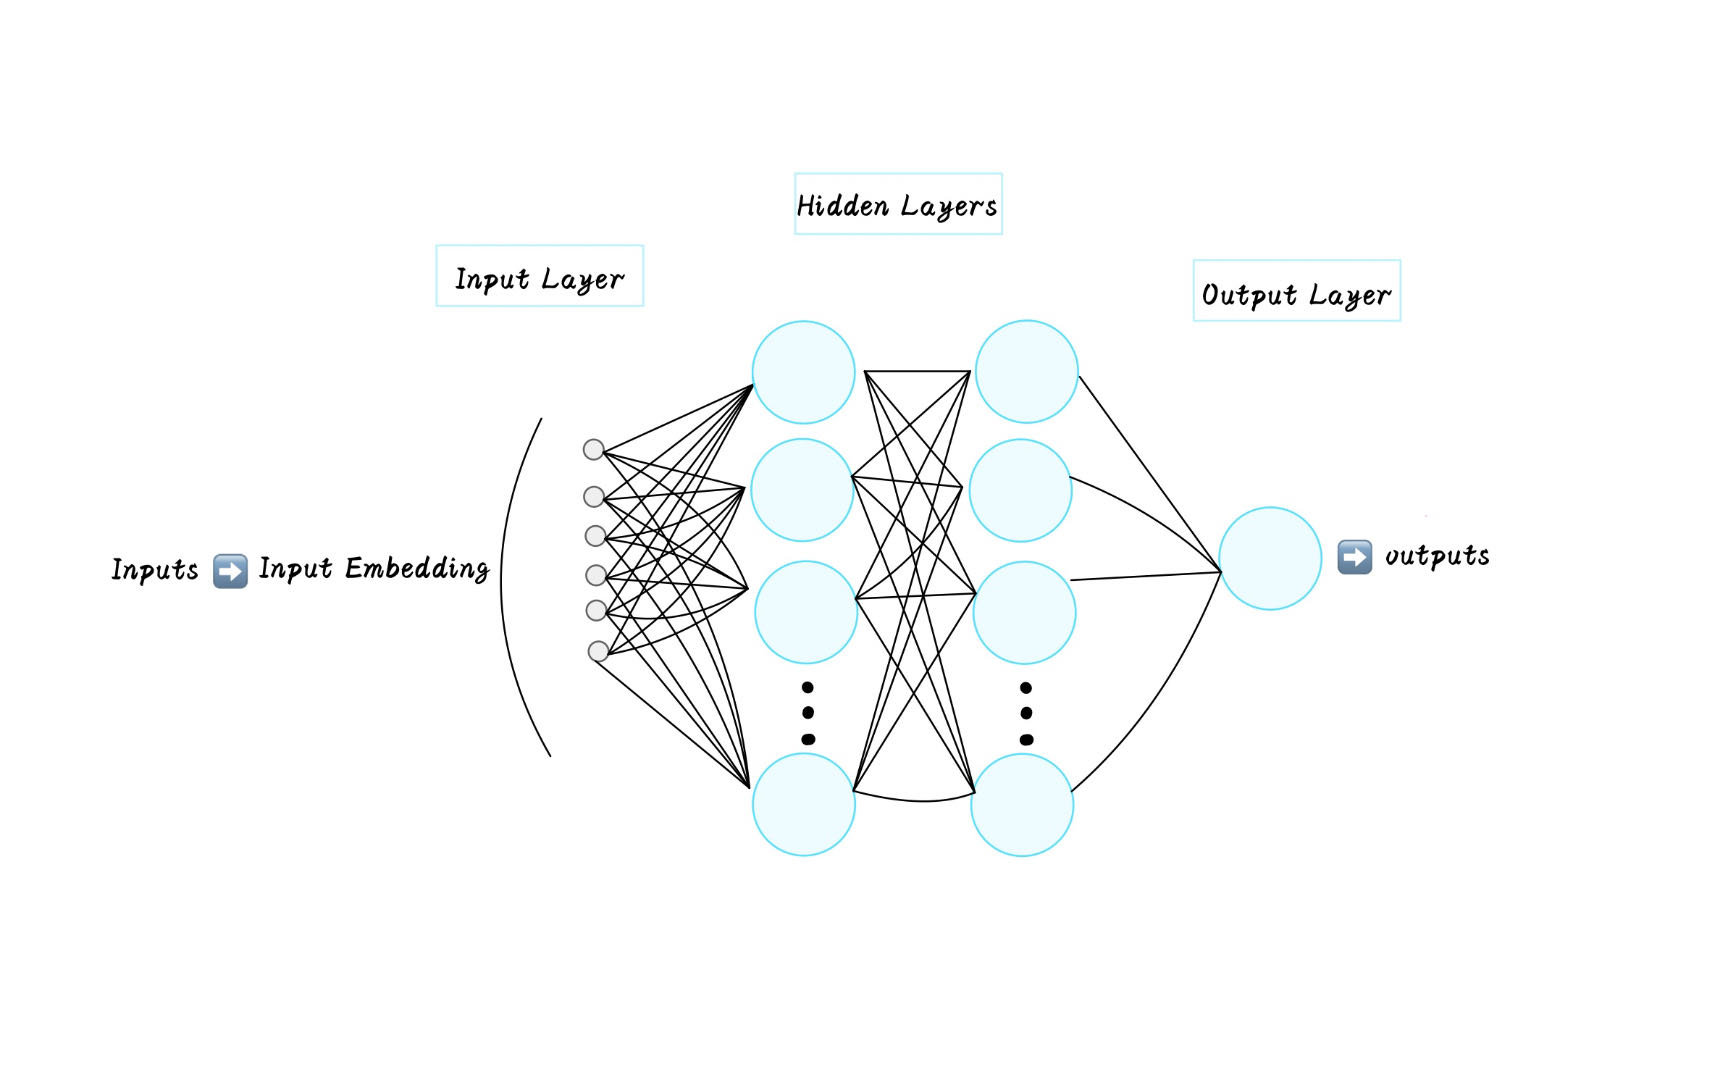
<center>Model architecture</center>

In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, hidden_dim)
        self.fc2= nn.Linear(hidden_dim,hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.85)

    def forward(self, text):
        embedded = self.embedding(text)
        embedded = embedded.mean(1)  # Assume averaging the embeddings is the feature
        hidden = self.dropout(F.relu(self.fc(embedded)))
        output = self.fc2(hidden)
        output=self.fc3(output)
        return output
    
# Hyperparameters
vocab_size = len(vocab)+1  # Size of your vocabulary
embedding_dim = 256
hidden_dim = 256
output_dim = 1  # Binary classification
learning_rate = 0.001
batch_size = 32
num_epochs = 10

model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

In [3]:
# Training loop
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    model.train()
    
    for text, labels in iterator:
        text=text.to(device)
        labels=labels.to(device).unsqueeze(1)
        
        outputs=model(text)
        loss=criterion(outputs,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# Evaluation function
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for text, labels in iterator:
            predictions = model(text).squeeze(1)
            loss = criterion(predictions, labels)
            epoch_loss += loss.item()
            
    return epoch_loss / len(iterator)


for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    valid_loss = evaluate(model, test_loader, criterion)
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

#Evaluation with F1 score
from sklearn.metrics import f1_score

def evaluate_f1_score(model, iterator):
    all_predictions = []
    all_labels = []
    model.eval()
    
    with torch.no_grad():
        for text, labels in iterator:
            predictions = torch.sigmoid(model(text)).squeeze(1)
            rounded_predictions = torch.round(predictions)
            all_predictions.extend(rounded_predictions.tolist())
            all_labels.extend(labels.tolist())
    
    return f1_score(all_labels, all_predictions)

f1 = evaluate_f1_score(model, test_loader)
print(f'F1 Score: {f1}')

C:\Users\86135\AppData\Local\Temp\ipykernel_5304\1618821494.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_padded_tensor = torch.tensor(train_padded_split, dtype=torch.long)
C:\Users\86135\AppData\Local\Temp\ipykernel_5304\1618821494.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_padded_tensor = torch.tensor(test_padded_split, dtype=torch.long)


Epoch: 01
	Train Loss: 0.686
	 Val. Loss: 0.668
Epoch: 02
	Train Loss: 0.673
	 Val. Loss: 0.653
Epoch: 03
	Train Loss: 0.649
	 Val. Loss: 0.625
Epoch: 04
	Train Loss: 0.591
	 Val. Loss: 0.559
Epoch: 05
	Train Loss: 0.509
	 Val. Loss: 0.512
Epoch: 06
	Train Loss: 0.445
	 Val. Loss: 0.510
Epoch: 07
	Train Loss: 0.379
	 Val. Loss: 0.498
Epoch: 08
	Train Loss: 0.320
	 Val. Loss: 0.554
Epoch: 09
	Train Loss: 0.271
	 Val. Loss: 0.568
Epoch: 10
	Train Loss: 0.236
	 Val. Loss: 0.608
F1 Score: 0.7159468438538206


## Genenate the submission file ##

In [ ]:
# Create a DataLoader for your test data
test_loader = DataLoader(test_padded, batch_size=32, shuffle=False)

def predict(model, iterator):
    model.eval()  # Set the model to evaluation mode
    predictions = []

    with torch.no_grad():  # No need to track gradients for predictions
        for text in iterator:
            text = text.to(device)
            output = model(text)  # Forward pass, get logits
            probability = torch.sigmoid(output)  # Apply sigmoid to get probabilities
            predicted_labels = torch.round(probability).squeeze()  # Convert probabilities to 0 or 1
            predictions.extend(predicted_labels.tolist())  # Extend the flat list with new sublist

    return predictions

# Use the trained model to predict labels for test data
test_predictions = predict(model, test_loader)

# Convert predictions to integers
test_predictions = [int(pred) for pred in test_predictions]

sample_submission = pd.read_csv("D:/kaggle/input/nlp-getting-started/sample_submission.csv")

sample_submission['target'] = test_predictions

sample_submission.to_csv('final_submission.csv', index=False)